<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [8]:
#@title Current Date
Today = '2021-09-15' #@param {type:"date"}


In [9]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "9312951" #@param {type:"string"}
Student_full_name = "Michael Scally" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

### Resources Used
https://www.youtube.com/watch?v=M-kBB2I4QlE&ab_channel=Montreal-Python

https://medium.com/@jdwittenauer/an-intro-to-probablistic-programming-de28cec81baf

https://www.youtube.com/watch?v=W-lqgS4IdaA&ab_channel=PeadarCoyle

http://inverseprobability.com/talks/notes/probabilistic-machine-learning.html

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [10]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [12]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Path, copy the path from your Drive
Path = '/content/drive/My Drive/Colab Notebooks/data/mnist-data/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


###Display the first few images
Display a few of the images to visualise before we start the normalisation or building the model

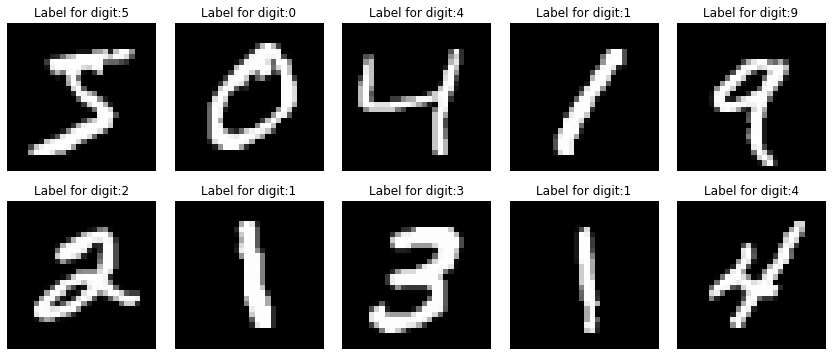

In [ ]:
# setup figure to show images; 2 rows, 5 cols
fig, axs = plt.subplots(2,5, figsize=(15, 6))
# setup spaces between images
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

#Take 10 random images from the X_train data to show, ensuring no repeats
sample_images = np.random.choice(X_train.shape[0], 10, replace=False)  

for i in range(10):
    image = X_train[i]
    axs[i].axis('off')
    # reshape and show the image
    pixels = X_train[i].reshape((28, 28))
    axs[i].imshow(pixels, cmap="Greys_r")
    # Show the labelled value for the image
    axs[i].set_title('Label for digit:' + str(y_train[i].astype(int)))

### Normalise the Data:
Transform the input features to a common scale between 0 and 1, instead of 0 to 255 in the data. 

In [ ]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [ ]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of the image, a series of 28 X 28 pixels
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

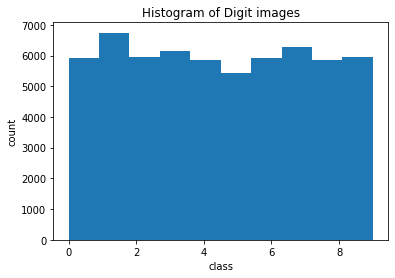

In [ ]:
#Plot the distribution of each of the classes, to see if any class is over or under represented
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [ ]:
# Specify the number of classes we want to train on
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
print(classes)

[2, 4, 8]


In [ ]:
# Specify number of instances we'll keep for each of our 3 digits. We are choosing a fixed number of samples for each digit here and not using all the data, just to train the model faster while still achieving a high degree of accuracy
inst_class = 1000
X = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
# Shaping inputs and labels in the right format    
X_train = np.vstack(X).astype(np.float64)
y_train = np.hstack(labels)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (3000, 784)
Shape of y_train: (3000,)


New Classes Distribution for selected three classes

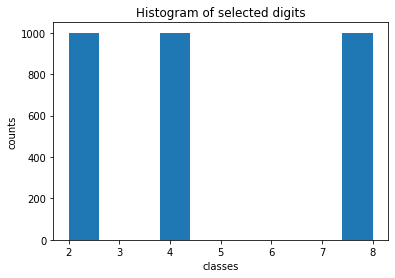

In [ ]:
# new histogram for selected digits
fig, ax = plt.subplots()

n, bins, patches = ax.hist(y_train, len(alltotal))
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of selected digits')
plt.show()

In [ ]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Original')

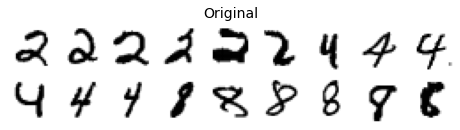

In [ ]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))
no_instances_to_show = 6
images_to_show_indexes = []

# Selecting a few label indices from each of the 3 classes to show:
for r in classes:
  indexes = np.where(y_train==r);
  images_to_show_indexes = np.append(images_to_show_indexes, np.random.choice(indexes[0], no_instances_to_show, replace=False)).astype(int)
    
# Plotting 'original' image
plot_digits(X_train[images_to_show_indexes,:],images_per_row=9)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [ ]:
### Split tha dataset in training and validation sets, I will set aside 20% for validation
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
# print shape of your validation and training set
print("Training input shape =", X_train.shape)
print("Training output shape =", y_train.shape)

print("Validation input shape =", X_val.shape)
print("Validation output shape =", y_val.shape)

Training input shape = (2400, 784)
Training output shape = (2400,)
Validation input shape = (600, 784)
Validation output shape = (600,)


### General-Recipe ML

Accuracy= 0.9483333333333334
Maximum probability for any class: 1.0
Minimum probability for any class: 0.5111059450085338
Probability scores for observation hardest to classify: [0.51110595 0.0012403  0.48765376]


Text(0.5, 1.0, 'Hardest image to classify')

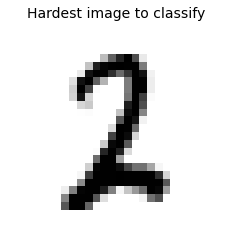

In [ ]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)
min_prob = np.amin(prob_classmax)
max_prob = np.amax(prob_classmax)

#Get the probability scores for each of the 3 classes for the image hardest to classify. This will return the probability for the image
#for each of the 3 classes 
prob_obs_hardest_classify = y_pred_logi_prob[np.argmin(prob_classmax)]

# Computing the original accuracy of the model
original_accuracy_score = accuracy_score(y_pred_log, y_val)

print("Accuracy=", original_accuracy_score)
print("Maximum probability for any class:", max_prob)
print("Minimum probability for any class:", min_prob)
print("Probability scores for observation hardest to classify:", prob_obs_hardest_classify)

#Plot image hardest to recognise
plot_digits(X_train[np.array([np.argmin(prob_classmax)]),:],images_per_row=9)
plt.title("Hardest image to classify", fontsize=14)

### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [ ]:
import sklearn.preprocessing

## Encode the class lables using the LabelBinarizer
## First digit  1 0 0
## Second Digit 0 1 0
## Third Digit  0 0 1
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))

#Number of features in the input data
nf = X_train.shape[1]

# number of classes we are looking to predict
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

print("Number of Features:", nf)
print("Number of Classes:", nc)

#We will initialise the prior with some random data for each beta class and feature
init_b = np.random.randn(nf, nc-1).astype(floatX)
print("init_b.shape:", init_b.shape)

#We will initialise the prior with some random data for alpha for each class
init_a = np.random.randn(nc-1).astype(floatX)
print("init_a.shape:", init_a.shape)

with pm.Model() as multi_logistic:
##    # Prior
  β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
  α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
  # we need to consider nc-1 features because the model is not identifiable
  # the softmax turns a vector into a probability that sums up to one
  # therefore we add zeros to go back to dimension nc
  # so that softmax returns a vector of dimension nc
  β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
  α1  = tt.tensor.concatenate([[0],α ],)
    
  # Likelihood
  mu = pm.math.matrix_dot(X_train,β1) + α1

  # It doesn't work if the problem is binary
  p = tt.tensor.nnet.nnet.softmax(mu)
  observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

Number of Features: 784
Number of Classes: 3
init_b.shape: (784, 2)
init_a.shape: (2,)


#### We now fit our training data to the model

In [ ]:
with multi_logistic:
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 10,676


In [ ]:
#We draw samples from the model as our posterior which will allow us to predict new values
dd = 300
posterior = approx.sample(draws=dd)

test image #232
posterior sample #110
true class= 2.0
classes: [2, 4, 8]
estimated prob= [0.00232375 0.         0.99767625]


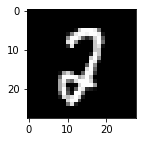

In [ ]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = random.randint(0, X_val.shape[0])

#select a sample in the posterior
s = random.randint(0, dd)

#Calculate the alpha and beta values from the posterior
beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])

image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image, cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))

#Here we calculat the estimated probability from the posterior alpha and beta values
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [ ]:
# Bayesian prediction
# return the class that has the highest posterior probability for each digit in the validation set
y_pred_Bayesian=[]

#Calculate the 
for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [ ]:
print(y_pred_Bayesian)

[0, 1, 1, 2, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 0, 

In [ ]:
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.8683333333333333


In [ ]:
# For each validation sample we get the class, Mean Probability and Standard Deviation
y_predB=[]

for i in range(X_val.shape[0]):
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])
  
y_predB= np.array(y_predB)

In [ ]:
# Show the predicted, mean probability and standard deviation for first 10 samples
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.65619004, 0.47370877],
       [1.        , 0.98854336, 0.08137704],
       [1.        , 0.69286929, 0.45969797],
       [2.        , 0.75290055, 0.4142463 ],
       [2.        , 0.61129393, 0.48538644],
       [2.        , 0.99288554, 0.08137704],
       [2.        , 0.82378859, 0.37853519],
       [0.        , 0.67112825, 0.46249324],
       [1.        , 0.84711955, 0.34698703],
       [0.        , 0.73884873, 0.43107102]])

In [ ]:
#sorting in descending order, show the predicted class, mean probability and standard deviation for first 10 samples
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.48505349, 0.5       ],
       [1.        , 0.49339605, 0.49998889],
       [0.        , 0.48829714, 0.49998889],
       [0.        , 0.50801286, 0.49995555],
       [2.        , 0.52140455, 0.49995555],
       [0.        , 0.50156519, 0.49995555],
       [1.        , 0.5082382 , 0.49995555],
       [0.        , 0.49090602, 0.49995555],
       [0.        , 0.49824556, 0.49995555],
       [2.        , 0.47685253, 0.49995555]])

In [ ]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([0.59740908, 0.99998613, 0.99999875, 0.99990263, 0.93704007,
       0.99996844, 0.99834312, 0.84508251, 0.85935129, 0.95709748,
       0.53738619, 0.99976213, 0.99443424, 0.99999953, 0.59222296,
       0.80683106, 0.97878639, 0.99992073, 0.96720732, 0.89496645,
       0.93768113, 0.99996521, 0.70723342, 0.98825641, 0.94390237,
       0.88291886, 0.99996916, 0.56370388, 0.9983832 , 0.98544195,
       0.51110595])

In [ ]:
#For the samples predicted incorrectly from the general-recipe model, show how the Bayesian prediction classified the same samples 
y_predB[y_pred_log != y_val,:]

array([[2.        , 0.96715677, 0.15095989],
       [2.        , 0.63661255, 0.47901519],
       [2.        , 0.68941303, 0.45376205],
       [2.        , 0.9838218 , 0.11469767],
       [2.        , 0.68267861, 0.46517619],
       [1.        , 0.89460091, 0.3       ],
       [0.        , 0.80748153, 0.38964371],
       [2.        , 0.88216846, 0.32102267],
       [2.        , 0.75157662, 0.42083251],
       [2.        , 0.84322201, 0.35041246],
       [0.        , 0.48829714, 0.49998889],
       [1.        , 0.49339605, 0.49998889],
       [1.        , 0.5668478 , 0.49121165],
       [2.        , 0.71897637, 0.44395946],
       [2.        , 0.82413524, 0.372678  ],
       [1.        , 0.42040273, 0.49408726],
       [2.        , 0.77369721, 0.40491426],
       [0.        , 0.38882331, 0.48368952],
       [1.        , 0.76336991, 0.42503595],
       [1.        , 0.81165175, 0.372678  ],
       [2.        , 0.61145808, 0.48848974],
       [2.        , 0.94384948, 0.20360637],
       [1.

In [ ]:
## Calculate the accuracy of the General recipe model on the easiest and most difficult samples to predict based on the Bayesian approach

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.92


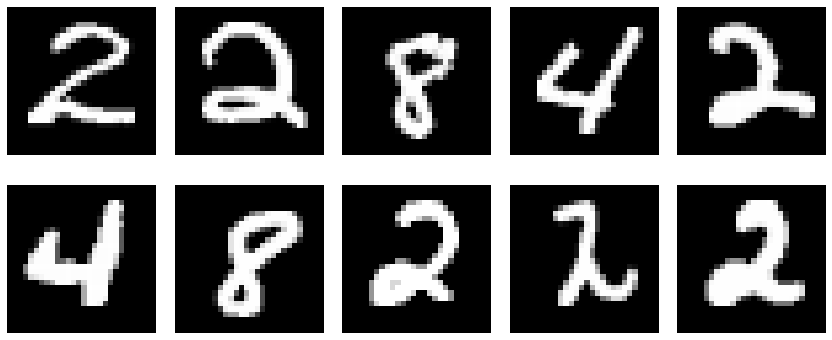

In [ ]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image, cmap="Greys_r")
    

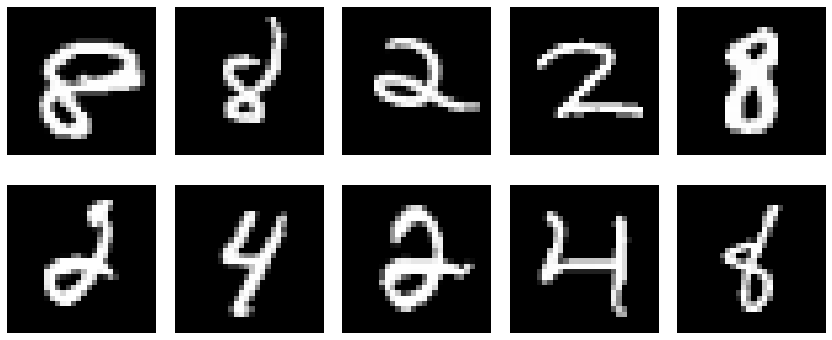

In [ ]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image, cmap="Greys_r")
    

###Removing the most difficult images


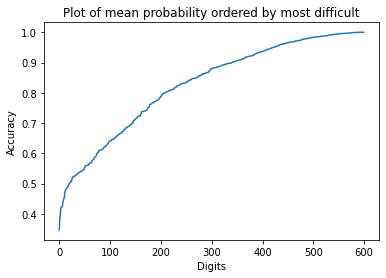

In [ ]:
#Plot the mean probability for each of the validation samples, ordered by accuracy ascending. This will show us the samples 
#with uncertainty where the model cannot predict accurately.
y_predB_sort_difficult = np.sort(y_predB[:,1])

plt.plot(y_predB_sort_difficult)
plt.title('Plot of mean probability ordered by most difficult')
plt.xlabel('Digits')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Remove the most difficult images from the General Receipe ML
#From the above plot, there is approx 50 samples that are below 0.7 accuracy threshold, so we can remove these. This will vary depending on the samples in our dataset
difficult = np.argsort(-y_predB[:,2])
new_X_val = np.delete(X_val, difficult[0:50], axis=0)
new_Y_val = np.delete(y_val, difficult[0:50], axis=0)
new_Y_pred = model_log.predict(new_X_val)

In [ ]:
#Calculate the Accuracy from the General Receipe ML algorithm with varying numbers of the most difficult samples removed
print('Original Accuracy score for General Receipe ML algorithm with (%s) difficult validation samples removed: %f' % (X_val.shape[0] - X_val.shape[0], original_accuracy_score))

new_accuracy = accuracy_score(new_Y_pred, new_Y_val)
print('New Accuracy Score for General Receipe ML algorithm with %s difficult validation samples removed: %f' % (X_val.shape[0] - new_X_val.shape[0], new_accuracy))

#Try again, removing even more of the difficult samples, in this case removing 100 samples
new_X_val = np.delete(X_val, difficult[0:100], axis=0)
new_Y_val = np.delete(y_val, difficult[0:100], axis=0)
new_Y_pred = model_log.predict(new_X_val)
new_accuracy = accuracy_score(new_Y_pred, new_Y_val)

print('New Accuracy Score for General Receipe ML algorithm with %s difficult validation samples removed: %f' % (X_val.shape[0] - new_X_val.shape[0], new_accuracy))

#Lets try again, this time we will remove another batch of difficult samples, to prove that our accuracy is improving
new_X_val = np.delete(X_val, difficult[0:250], axis=0)
new_Y_val = np.delete(y_val, difficult[0:250], axis=0)
new_Y_pred = model_log.predict(new_X_val)
new_accuracy = accuracy_score(new_Y_pred, new_Y_val)

print('New Accuracy Score for General Receipe ML algorithm with %s difficult validation samples removed: %f' % (X_val.shape[0] - new_X_val.shape[0], new_accuracy))

#Lets try again, this time we will remove all but the easiest 50 samples we should be getting an accuracy close to 1
new_X_val = np.delete(X_val, difficult[0:550], axis=0)
new_Y_val = np.delete(y_val, difficult[0:550], axis=0)
new_Y_pred = model_log.predict(new_X_val)
new_accuracy = accuracy_score(new_Y_pred, new_Y_val)

print('New Accuracy Score for General Receipe ML algorithm with %s difficult validation samples removed: %f' % (X_val.shape[0] - new_X_val.shape[0], new_accuracy))

Original Accuracy score for General Receipe ML algorithm with (0) difficult validation samples removed: 0.948333
New Accuracy Score for General Receipe ML algorithm with 50 difficult validation samples removed: 0.947273
New Accuracy Score for General Receipe ML algorithm with 100 difficult validation samples removed: 0.954000
New Accuracy Score for General Receipe ML algorithm with 250 difficult validation samples removed: 0.974286
New Accuracy Score for General Receipe ML algorithm with 550 difficult validation samples removed: 1.000000


In [21]:
#Export notebook in pretty PDF format
!wget -nc https://github.com/mike-scally/ET5003/blob/main/Etivity_1_MikeScally_9312951.ipynb

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from colab_pdf import colab_pdf

colab_pdf('Etivity_1_MikeScally_9312951_New.ipynb')

File ‘Etivity_1_MikeScally_9312951.ipynb’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Etivity_1_MikeScally_9312951_New.ipynb to pdf
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed (u'errorDetails' was unexpected)

Failed validating u'additionalProperties' in error:

On instance[u'cells'][61][u'outputs'][1]:
{u'ename': u'ModuleNotFoundError',
 u'errorDetails': {u'actions': [{u'action': u'open_url',
                                 u'actionText': u'Open Examples',
                                 u'url': u'/notebooks/snippets/importing_libraries.ipynb'}]},
 u'evalue': u'ignored',
 u'output_type': u'error',
 u'traceback': [u'\x1b---------------------------------------------------------------------------\x1b',
                u'\x1bModuleNotFoundError\x1b                       Traceback (most recent call last)',
                u"\x1b<ipython-input-2-d0c549c712df>\x1b in \x1b<module>\x1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'

In [22]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Etivity_1_MikeScally_9312951.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.



ValueError: ignored

In [25]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
!wget -nc https://github.com/mike-scally/ET5003/blob/main/Etivity_1_MikeScally_9312951.ipynb
#colab_pdf('Etivity_1_MikeScally_9312951.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.

File ‘Etivity_1_MikeScally_9312951.ipynb’ already there; not retrieving.



## Summary
In our meetings, we discussed what is the boundary for difficult vs easy images to classify. In the traffic light sample, it looks at samples from the validation data and builds an array based on mean and rank and sorts for easy and difficult images. Is there a more accurate way or cutoff in the probability that determines that difficult samples that should be removed?

Anthony used a loss curve when removing more and more difficult samples, and it showed the accuracy stabl=ilised when approx 750 samples were removed. However, it seems this is a large number to remove from I think the validation set was 3000 in total.

There was a discussion around the sampling for the posterior, what determines the best number of samples to choose in order to determine the most accurate probability for a specific class

IN building the multinomial logistic regression model, the model considers nc-1 features, and the reason given is the model is not identifiable. What makes a model identifiable, or when can you use all classes?


Populate this section with all of your findings and comments fron the discussion with your peers.